In [1]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '5'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import jax.numpy as jnp
from jax import random, vmap, clear_caches, jit
import numpy as np

import optax
import matplotlib.pyplot as plt
from functools import partial

from data import dataset_Poisson2D_finite_diff
from conj_grad import ConjGrad, apply_LLT
from model import MessagePassing, FullyConnectedNet, PrecNet, ConstantConv1d, MessagePassingWithDot

from utils import params_count, asses_cond, iter_per_residual, batch_indices
from data import direc_graph_from_linear_system_sparse
from train import train

# Make dataset

In [3]:
grid = 50
N_samples_train = 20
N_samples_test = 5

In [4]:
A_train, b_train, u_exact_train, bi_edges_train = dataset_Poisson2D_finite_diff(grid, N_samples_train, seed=42, rhs_distr=[5, 5, 2], random_rhs=False)
A_test, b_test, u_exact_test, bi_edges_test = dataset_Poisson2D_finite_diff(grid, N_samples_test, seed=43, rhs_distr=[5, 5, 2], random_rhs=False)

2024-04-13 11:46:33.030799: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
# Normalize linear system in form: norm**(-1) * A @ u = f * norm**(-1)

# norm_train = jnp.linalg.norm(A_train.data, axis=1)
# b_train = jnp.einsum('bi, b -> bi', b_train, 1./norm_train)
# A_train = A_train / norm_train[..., None, None]

# norm_test = jnp.linalg.norm(A_test.data, axis=1)
# b_test_norm = jnp.einsum('bi, b -> bi', b_test, 1./norm_test)
# A_test_norm = A_test / norm_test[..., None, None]

In [6]:
b_test_norm = b_test
A_test_norm = A_test

# Train model

In [7]:
seed = 42
NodeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=ConstantConv1d)
EdgeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=ConstantConv1d)
EdgeDecoder = FullyConnectedNet(features=[16, 16, 1], N_layers=2, key=random.PRNGKey(seed), layer_=ConstantConv1d)

mp_rounds = 5
MessagePass = MessagePassingWithDot(#MessagePassing(
    update_edge_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=ConstantConv1d),
    update_node_fn = FullyConnectedNet(features=[32, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=ConstantConv1d),
    mp_rounds=mp_rounds
)

model = PrecNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)
print(f'Parameter number: {params_count(model)}')

Parameter number: 2753


In [8]:
batch_size = 4
lr = 1e-2

steps_per_batch = N_samples_train // batch_size
start, stop, step = 300*steps_per_batch, 1001*steps_per_batch, 300*steps_per_batch
decay_size = .5
lr = optax.piecewise_constant_schedule(
    lr,
#     {k: v for k, v in zip([37], [1e-1])}
    {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
)

In [9]:
# data = (X_train, X_test, y_train, y_test)
data = (
    [A_train, b_train, bi_edges_train, u_exact_train],
    [A_test_norm, b_test_norm, bi_edges_test, u_exact_test],
    jnp.array([1]), jnp.array([1])
)
train_config = {
    'optimizer': optax.adam,
    'lr': lr,
    'optim_params': {},#{'weight_decay': 1e-8}, 
    'epoch_num': 1000,
    'batch_size': batch_size
}

In [10]:
model, losses = train(model, data, train_config, loss_name='llt', with_cond=False)

In [11]:
L = vmap(model, in_axes=(0, 0, 0, 0, 0), out_axes=(0))(*direc_graph_from_linear_system_sparse(A_test_norm, b_test_norm)[:-1], bi_edges_test)
del model, data, A_test_norm, b_test_norm,A_train, b_train, u_exact_train, bi_edges_train
clear_caches()

Final values
  train loss: 26267.0293
   test loss: 47795.9844

Minimim test loss `47795.9844` at epoch `999`

Test lhs A cond: 1053, test P^(-1)A cond: 41


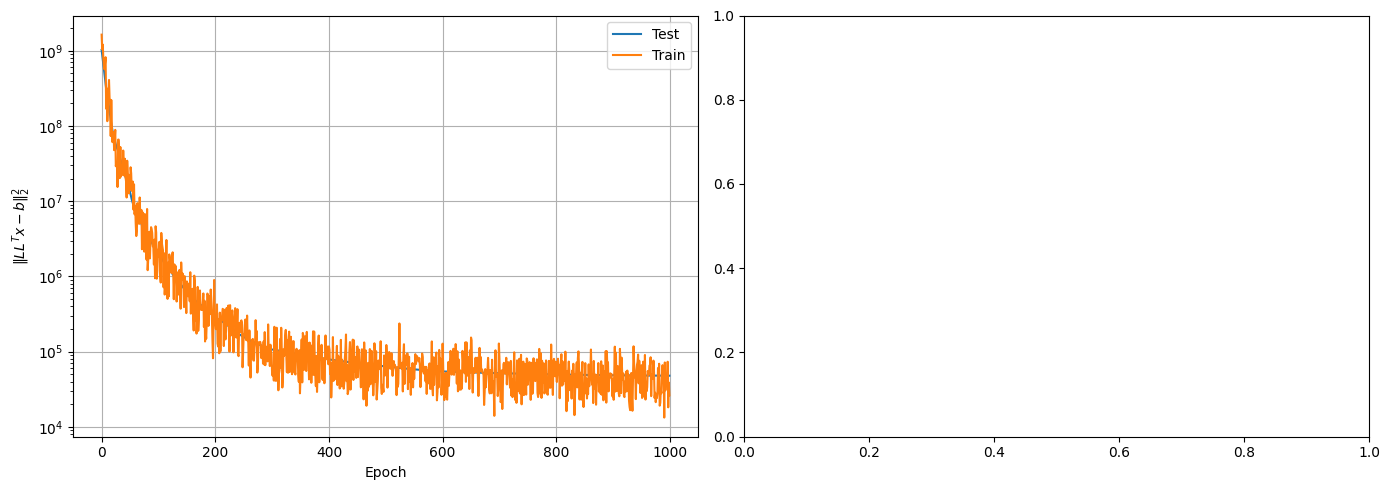

In [12]:
_, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(len(losses[0])), losses[1], label='Test')
axes[0].plot(range(len(losses[0])), losses[0], label='Train')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('$\|LL^Tx - b\|_2^2$');
axes[0].grid();

# axes[1].plot(range(len(losses[0])), losses[2], label='Test')
# axes[1].legend()
# axes[1].set_yscale('log')
# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Condition number of $(LL^T)^{-1}A$')
# axes[1].grid();

# for vl in [110]:#[13, 17, 22, 25, 29, 39, 59, 79]:
#     axes[0].axvline(vl, 0, 1e11, linestyle='--', c='k')
#     axes[1].axvline(vl, 0, 1e11, linestyle='--', c='k')

plt.tight_layout()

cond_A, cond_LLT = jit(asses_cond)(A_test, L)
print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}')#\n    LLT cond: {losses[2][-1]:.0f}')
print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
# print(f'\nMinimim test P^(-1)A cond `{jnp.min(losses[2]).item():.0f}` at epoch `{jnp.argmin(losses[2]).item():.0f}`')
print(f'\nTest lhs A cond: {cond_A:.0f}, test P^(-1)A cond: {cond_LLT:.0f}')

# Apply model to CG

In [13]:
# Not preconditioned
X_I, R_I = ConjGrad(A_test, b_test, N_iter=300, prec_func=None, seed=42)

In [14]:
# P = LL^T
prec = partial(apply_LLT, L=L)

X_LLT, R_LLT = ConjGrad(A_test, b_test, N_iter=300, prec_func=prec, seed=42)

        Simple CG: {0.001: 115, 1e-06: 169, 1e-12: 258}
Preconditioned CG: {0.001: 22, 1e-06: 33, 1e-12: 56}


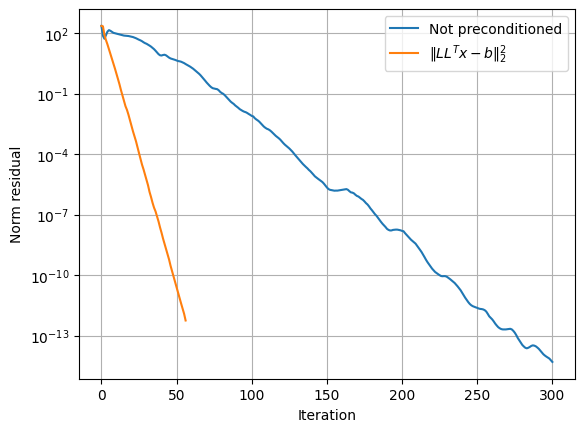

In [15]:
plt.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), label="Not preconditioned")
plt.plot(range(R_LLT.shape[-1]), jnp.linalg.norm(R_LLT, axis=1).mean(0), label="$\|LL^Tx - b\|_2^2$")

plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.legend();
plt.yscale('log')
plt.grid();

# plt.ylim([1e-15, 1e0]);
# plt.vlines(110, 1e-15, 1, linestyle='--', color='k')

res_I_dict = iter_per_residual(R_I)
res_LLT_dict = iter_per_residual(R_LLT)
print('        Simple CG:', res_I_dict)
print('Preconditioned CG:', res_LLT_dict)

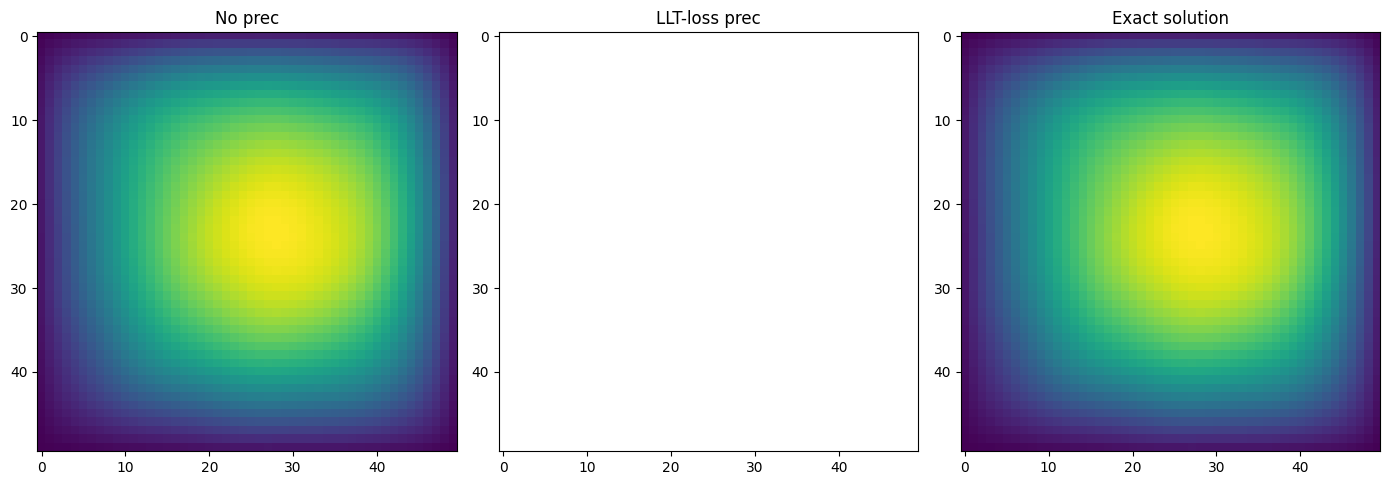

In [16]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('LLT-loss prec')
axes[2].set_title('Exact solution')
    
plt.tight_layout()

In [17]:
jnp.abs(b_test[0, ...] - A_test[0, ...].todense() @ u_exact_test[0, ...]).max()

Array(0.0002487, dtype=float32)